# Create data for stacking code testing

In [2]:
import numpy as np
#wow
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes

In [3]:
data_path = Path("/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/")
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [4]:
tile = "80613"
tile_path = data_path / tile /"deep"

In [14]:
z_table = Table()
spectra = desispec.spectra.Spectra()

for file_path in tile_path.glob("zbest-*"):

    z_petal = Table.read(file_path, hdu="ZBEST")
    fibermap_petal = Table.read(file_path, hdu="FIBERMAP")[0:500]

    merged_table = join(z_petal, fibermap_petal, keys="TARGETID", metadata_conflicts="silent")
    print(len(merged_table))
    mask = ((merged_table["SV1_BGS_TARGET"] & bgs_mask.mask("BGS_BRIGHT"))>0) & (merged_table["FIBERSTATUS"] == 0)
    rfmag = 22.5 - 2.5 * np.log10(merged_table["FIBERFLUX_R"])
    mask &= (rfmag<19)
    mask &= (merged_table["Z"]>0.1) & (merged_table["Z"]<0.2)
    mask &= (merged_table["SPECTYPE"]=="GALAXY")
    mask &= (merged_table["DELTACHI2"]>1000)
    merged_table = merged_table[mask]
#     z_table = vstack([z_table, merged_table])

    if np.sum(mask):
        spec = desispec.io.read_spectra(str(file_path).replace("zbest","coadd") )
        # CAUTION desispec uses EXPID + FIBER to determine uniqueness
#         spec.fibermap["NIGHT"] = np.arange(len(spec.fibermap))
#         spec.fibermap["EXPID"] = np.arange(len(spec.fibermap))
        spec = myspecselect.myspecselect(spec,targets= merged_table["TARGETID"])

        z_table = vstack([z_table, merged_table])
        spectra = myspecupdate.myspecupdate(spectra, spec)

500


<ipython-input-14-1740dec2fd6a>:12: RuntimeWarning: invalid value encountered in log10
  rfmag = 22.5 - 2.5 * np.log10(merged_table["FIBERFLUX_R"])


INFO:spectra.py:253:read_spectra: iotime 0.852 sec to read coadd-0-80613-deep.fits at 2021-04-07T12:56:00.123937
500
INFO:spectra.py:253:read_spectra: iotime 0.917 sec to read coadd-1-80613-deep.fits at 2021-04-07T12:56:01.890292
500
INFO:spectra.py:253:read_spectra: iotime 0.980 sec to read coadd-7-80613-deep.fits at 2021-04-07T12:56:03.550325
500
INFO:spectra.py:253:read_spectra: iotime 0.909 sec to read coadd-3-80613-deep.fits at 2021-04-07T12:56:05.224832
500


<ipython-input-14-1740dec2fd6a>:12: RuntimeWarning: divide by zero encountered in log10
  rfmag = 22.5 - 2.5 * np.log10(merged_table["FIBERFLUX_R"])


INFO:spectra.py:253:read_spectra: iotime 0.902 sec to read coadd-5-80613-deep.fits at 2021-04-07T12:56:06.938103
500
INFO:spectra.py:253:read_spectra: iotime 0.890 sec to read coadd-9-80613-deep.fits at 2021-04-07T12:56:08.529514
500
500
INFO:spectra.py:253:read_spectra: iotime 0.738 sec to read coadd-8-80613-deep.fits at 2021-04-07T12:56:10.177747
500
INFO:spectra.py:253:read_spectra: iotime 0.844 sec to read coadd-4-80613-deep.fits at 2021-04-07T12:56:11.763279
500


In [21]:
z_table.columns

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','NUMEXP','NUMTILE','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','PRIORITY','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKID','BRICK_OBJID','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','BRICKNAME','EBV','FLUX_W1','FLUX_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_MWS_TARGET','DESI_TARGET','BGS_TARGET','MWS_TARGET','NUM_ITER','FIBER_X','FIBER_Y','DELTA_X','DELTA_Y','FIBER_RA','FIBER_DEC','EXPTIME','NIGHT','EXPID','MJD

In [16]:
spectra.num_targets()

16

Text(0.5, 0, 'Spec-Z')

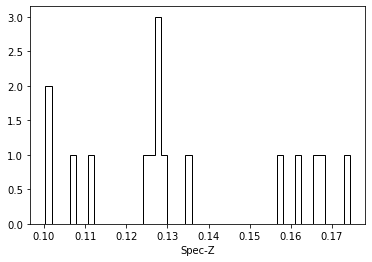

In [17]:
_=plt.hist(z_table["Z"], histtype="step", color="k", bins=50)
plt.xlabel("Spec-Z")

Text(0.5, 0, 'Spec-Z')

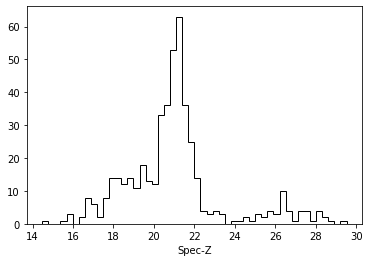

In [8]:
_=plt.hist(rfmag, histtype="step", color="k", bins=50)
plt.xlabel("Spec-Z")

In [18]:
z_table.write(my_path/"zcat_bright.fits")
desispec.io.write_spectra(my_path/"spectra_bright.fits", spectra)

INFO:spectra.py:154:write_spectra: iotime 5.347 sec to write spectra_bright.fits at 2021-04-07T12:57:29.485401


'/global/cscratch1/sd/bid13/stack-spectra/spectra_bright.fits'

In [ ]:
plt.plot(spectra.flux["brz"][8])

In [ ]:
sky = desispec.io.read_spectra("/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80609/deep/coadd-0-80609-deep.fits")

In [ ]:
x = sky.flux["b"][sky.fibermap["OBJTYPE"]=="SKY"]

In [ ]:
plt.plot(x[0])

# Curate the sky spectra

In [21]:
spectra = desispec.spectra.Spectra()

for file_path in tile_path.glob("coadd-*.fits"):
    spec = desispec.io.read_spectra(str(file_path))
    targets = np.unique(spec.fibermap[(spec.fibermap["OBJTYPE"]=="SKY")&(spec.fibermap["FIBERSTATUS"] == 0)]["TARGETID"])
    spec = myspecselect.myspecselect(spec,targets= targets)
    spectra = myspecupdate.myspecupdate(spectra, spec)

INFO:spectra.py:253:read_spectra: iotime 0.463 sec to read coadd-2-80613-deep.fits at 2021-04-08T19:30:45.058872
INFO:spectra.py:253:read_spectra: iotime 0.433 sec to read coadd-6-80613-deep.fits at 2021-04-08T19:30:46.025279
INFO:spectra.py:253:read_spectra: iotime 0.424 sec to read coadd-3-80613-deep.fits at 2021-04-08T19:30:47.135556
INFO:spectra.py:253:read_spectra: iotime 0.495 sec to read coadd-5-80613-deep.fits at 2021-04-08T19:30:48.239155
INFO:spectra.py:253:read_spectra: iotime 0.426 sec to read coadd-1-80613-deep.fits at 2021-04-08T19:30:49.432993
INFO:spectra.py:253:read_spectra: iotime 0.475 sec to read coadd-7-80613-deep.fits at 2021-04-08T19:30:50.545980
INFO:spectra.py:253:read_spectra: iotime 0.413 sec to read coadd-0-80613-deep.fits at 2021-04-08T19:30:51.750338
INFO:spectra.py:253:read_spectra: iotime 0.477 sec to read coadd-4-80613-deep.fits at 2021-04-08T19:30:52.980376
INFO:spectra.py:253:read_spectra: iotime 0.466 sec to read coadd-8-80613-deep.fits at 2021-04-08

In [22]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,TILEID,COADD_NUMEXP,COADD_EXPTIME,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_X,MEAN_FIBER_Y,MEAN_FIBER_RA,MEAN_FIBER_DEC,MEAN_FIBERASSIGN_X,MEAN_FIBERASSIGN_Y,FIRST_NIGHT,LAST_NIGHT,NUM_NIGHT,FIRST_EXPID,LAST_EXPID,NUM_EXPID,FIRST_TILEID,LAST_TILEID,NUM_TILEID,FIRST_FIBER,LAST_FIBER,NUM_FIBER,FIRST_MJD,LAST_MJD,NUM_MJD
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int32,int16,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,int32,int32,int16,int32,int32,int16,int32,int32,int16,int32,int32,int16,float32,float32,int16
616094076919349920,2,462,2462,1355,0,104.32387245935884,55.26118047634372,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-1,0.9174065276145617,63,9011,602604,672,,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,1041p552,0.0,0.0,0.0,-0.016076276,-0.004632345,-0.06576146,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,4294967296,0,0,80613,9,2700.0,0.0013333333,0.0062003583,0.0076666665,0.013008544,349.7378,-205.3469,104.32385991614936,55.261210066229104,349.8489,-205.31639,20201218,20201221,2,68657,69230,9,80613,80613,1,1355,1355,1,59202.25,59205.184,9
616094076919350333,2,421,2421,1389,0,104.41631947297135,55.350931904134846,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-1,0.8616787688305988,63,9011,602604,1085,,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,1041p552,0.0,0.0,0.0,-0.008203445,0.009926878,0.092257194,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,4294967296,0,0,80613,6,1800.0,0.004333333,0.006871843,0.006888889,0.012762793,333.9222,-182.21834,104.4162876940037,55.35095874931574,334.03415,-182.1946,20201218,20201221,2,68657,69230,9,80613,80613,1,1389,1389,1,59202.25,59205.184,9
616094076923544310,2,375,2375,1391,0,104.55049527711816,55.28362990539857,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-1,0.8875003023743516,63,9011,602605,758,,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,1046p552,0.0,0.0,0.0,-0.008846673,-0.03795367,0.044057135,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,4294967296,0,0,80613,9,2700.0,0.0012222222,0.0053229067,0.006888889,0.012978615,314.83688,-199.609,104.55048402292806,55.28365670034189,314.9458,-199.58557,20201218,20201221,2,68657,69230,9,80613,80613,1,1391,1391,1,59202.25,59205.184,9
616094076923544370,2,333,2333,1399,0,104.68277305055021,55.29718741281881,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-1,0.811166828123253,63,9011,602605,818,,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,1046p552,0.0,0.0,0.0,0.020868694,-0.011722391,0.080163315,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,4294967296,0,0,80613,9,2700.0,0.0022222223,0.0046427962,0.007222222,0.01288841,294.75012,-196.17812,104.68275505968357,55.297215634229694,294.8563,-196.1574,20201218,20201221,2,68657,69230,9,80613,80613,1,1399,1399,1,59202.25,59205.184,9
616094080371261525,2,465,2465,1379,0,104.2970561969515,55.386936493708184,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-1,0.8199284765065072,63,9011,603427,85,,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,1042p555,0.0,0.0,0.0,0.0027853826,0.016839106,-0.054598745,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,4

In [23]:
old_spec = desispec.io.read_spectra(my_path /  "spectra_bright.fits")

INFO:spectra.py:253:read_spectra: iotime 0.122 sec to read spectra_bright.fits at 2021-04-08T19:35:30.797839


In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=old_spec.fibermap["MEAN_FIBER_RA"]*u.degree, dec=old_spec.fibermap["MEAN_FIBER_DEC"]*u.degree)
catalog = SkyCoord(ra=spectra.fibermap["MEAN_FIBER_RA"]*u.degree, dec=spectra.fibermap["MEAN_FIBER_DEC"]*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

In [28]:
sky_targets = spectra.fibermap[idx]["TARGETID"]

In [29]:
sky_spec = myspecselect.myspecselect(spectra,targets= sky_targets)

In [30]:
desispec.io.write_spectra(my_path/"sky_bright.fits", sky_spec)

INFO:spectra.py:154:write_spectra: iotime 34.361 sec to write sky_bright.fits at 2021-04-08T19:43:07.613755


'/global/cscratch1/sd/bid13/stack-spectra/sky_bright.fits'

In [31]:
sky_spec.num_targets()

16